## Unsurprised Concept drift for abnormal detection

* using nn-gans for sequential cell type detection
* cell life-cycle detection

### Implement using PyTorch
* genetative adversial networks using nerual networks

In [1]:
%load_ext watermark
%watermark -v -p torch,numpy\

CPython 2.7.6
IPython 5.4.1

torch 0.1.12_2
numpy 1.12.1


In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image
from torch.autograd import Variable

### params setting

In [3]:
# dataset ='cifar10'
dataroot = './dataset'
# workers
batchSize=64
imageSize=64
nz=100
ngf=64
ndf=64
niter=25
lr=0.002
lrD=0.00005
lrG=0.00005
beta1=0.5
# cuda
ngpu=1
netG=''
netD=''
outf='results'
nc=3
cuda=True
manualSeed=None
# manualSeed=9853
workers=2


lrD=0.00005
lrG=0.00005
_Diters=5
clamp_lower=-0.01
clamp_upper=0.01
experiment='results'
adam=False


In [4]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw ')
# parser.add_argument('--dataroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
# parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda', action='store_true', help='enables cuda')
# parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--netG', default='', help="path to netG (to continue training)")
# parser.add_argument('--netD', default='', help="path to netD (to continue training)")
# parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
# parser.add_argument('--manualSeed', type=int, help='manual seed')

# opt = parser.parse_args()
# print(opt)

In [5]:
try:
    os.makedirs(outf)
except OSError:
    pass

if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if cuda:
    torch.cuda.manual_seed_all(manualSeed)

cudnn.benchmark = False

Random Seed:  6176


### data loading

In [6]:
# # dataset == 'cifar10'
# dataset = dset.CIFAR10(root=dataroot, download=True,
#                        transform=transforms.Compose([
#                            transforms.Scale(imageSize),
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                        ])
# )
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
#                                          shuffle=True, num_workers=int(workers))

In [7]:
trainset = dset.ImageFolder(root='cellcycle/', 
                            transform=transforms.Compose([
                                transforms.Scale(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,shuffle=True, num_workers=2)

print(trainset.class_to_idx)

{'1': 1, '0': 0, '3': 3, '2': 2}


### network definition

In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # inputs size 100 random numbers
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4,
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=ngf * 8),
            nn.ReLU(True),
            
            # intermediate output size (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ngf * 4),
            nn.ReLU(True),
            
            # inter-output size (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ngf * 2),
            nn.ReLU(True),
            
            # inter-output size (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # inter-output size (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # output size (nc) x 64 x 64
        )
    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output



class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.interm = None
        self.main = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=nc*64*64, out_channels=ngf * 8, kernel_size=8,
#                                stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(num_features=ngf * 8),
#             nn.ReLU(True),
            
            # input size (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, out_channels=512, kernel_size=4, 
                      stride=1, padding=0, bias=False),
#             nn.Linear(256, 1),
#             nn.Sigmoid()            ######################### drop the final sigmoid function
            # output 1 x ? x ?
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
#             nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True),
            nn.Sigmoid(),
#             nn.Dropout(),
            nn.Linear(1024, 256),
            nn.Sigmoid(),
#             #nn.ReLU(True),
#             # nn.Dropout(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            _output = self.main(input)
            _output = _output.view(_output.size(0), -1)
            output = self.classifier(_output)
            self.interm = output
#         output = output.mean(0)
        return output.view(1, -1)

* print networks

In [15]:
netG = _netG(ngpu)
netG.apply(weights_init)
print(netG)

netD = _netD(ngpu)
netD.apply(weights_init)
print(netD)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)
_netD (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

### Define Optimizer

In [16]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

if cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
# optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

### Start Training

* learn the distribution of healthy cells

In [17]:
dataloader = trainloader

In [18]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))


[0/25][0/31] Loss_D: 1.3927 Loss_G: 1.6416 D(x): 0.5248 D(G(z)): 0.5266 / 0.1937
[0/25][1/31] Loss_D: 1.3952 Loss_G: 1.8920 D(x): 0.3609 D(G(z)): 0.3120 / 0.1508
[0/25][2/31] Loss_D: 0.2940 Loss_G: 2.5985 D(x): 0.8845 D(G(z)): 0.1573 / 0.0744
[0/25][3/31] Loss_D: 0.1279 Loss_G: 3.1724 D(x): 0.9525 D(G(z)): 0.0761 / 0.0419
[0/25][4/31] Loss_D: 0.0732 Loss_G: 3.5047 D(x): 0.9702 D(G(z)): 0.0420 / 0.0301
[0/25][5/31] Loss_D: 0.0532 Loss_G: 3.7122 D(x): 0.9776 D(G(z)): 0.0301 / 0.0244
[0/25][6/31] Loss_D: 0.0435 Loss_G: 3.8597 D(x): 0.9814 D(G(z)): 0.0244 / 0.0211
[0/25][7/31] Loss_D: 0.0376 Loss_G: 3.9756 D(x): 0.9838 D(G(z)): 0.0211 / 0.0188
[0/25][8/31] Loss_D: 0.0335 Loss_G: 4.0732 D(x): 0.9855 D(G(z)): 0.0188 / 0.0170
[0/25][9/31] Loss_D: 0.0306 Loss_G: 4.1578 D(x): 0.9868 D(G(z)): 0.0172 / 0.0156
[0/25][10/31] Loss_D: 4.4232 Loss_G: 0.0324 D(x): 0.9876 D(G(z)): 0.9879 / 0.9681
[0/25][11/31] Loss_D: 3.4790 Loss_G: 0.4812 D(x): 0.9682 D(G(z)): 0.9681 / 0.6181
[0/25][12/31] Loss_D: 1.46

[3/25][8/31] Loss_D: 1.4416 Loss_G: 0.8029 D(x): 0.7106 D(G(z)): 0.6186 / 0.4669
[3/25][9/31] Loss_D: 1.3889 Loss_G: 1.1441 D(x): 0.5945 D(G(z)): 0.5235 / 0.3198
[3/25][10/31] Loss_D: 1.3330 Loss_G: 1.0568 D(x): 0.4304 D(G(z)): 0.3556 / 0.3486
[3/25][11/31] Loss_D: 1.3262 Loss_G: 0.5707 D(x): 0.4453 D(G(z)): 0.3882 / 0.5792
[3/25][12/31] Loss_D: 1.4087 Loss_G: 0.6288 D(x): 0.6597 D(G(z)): 0.5927 / 0.5489
[3/25][13/31] Loss_D: 1.4734 Loss_G: 0.7655 D(x): 0.6155 D(G(z)): 0.5886 / 0.4829
[3/25][14/31] Loss_D: 1.4218 Loss_G: 0.8845 D(x): 0.5027 D(G(z)): 0.4868 / 0.4257
[3/25][15/31] Loss_D: 1.4169 Loss_G: 0.8105 D(x): 0.4776 D(G(z)): 0.4658 / 0.4553
[3/25][16/31] Loss_D: 1.4666 Loss_G: 0.7607 D(x): 0.4702 D(G(z)): 0.4879 / 0.4742
[3/25][17/31] Loss_D: 1.4128 Loss_G: 0.7773 D(x): 0.4729 D(G(z)): 0.4705 / 0.4638
[3/25][18/31] Loss_D: 1.3575 Loss_G: 0.8047 D(x): 0.4879 D(G(z)): 0.4584 / 0.4504
[3/25][19/31] Loss_D: 1.3541 Loss_G: 0.7687 D(x): 0.5114 D(G(z)): 0.4790 / 0.4682
[3/25][20/31] Loss

[6/25][16/31] Loss_D: 0.4028 Loss_G: 1.9487 D(x): 0.7844 D(G(z)): 0.0857 / 0.2286
[6/25][17/31] Loss_D: 0.7931 Loss_G: 2.4831 D(x): 0.9221 D(G(z)): 0.3102 / 0.0867
[6/25][18/31] Loss_D: 0.1788 Loss_G: 2.5875 D(x): 0.9229 D(G(z)): 0.0922 / 0.0788
[6/25][19/31] Loss_D: 0.1655 Loss_G: 2.7490 D(x): 0.9290 D(G(z)): 0.0863 / 0.0656
[6/25][20/31] Loss_D: 0.1358 Loss_G: 2.8415 D(x): 0.9379 D(G(z)): 0.0690 / 0.0596
[6/25][21/31] Loss_D: 0.1310 Loss_G: 2.9115 D(x): 0.9388 D(G(z)): 0.0648 / 0.0557
[6/25][22/31] Loss_D: 0.1388 Loss_G: 3.0679 D(x): 0.9481 D(G(z)): 0.0793 / 0.0468
[6/25][23/31] Loss_D: 0.1319 Loss_G: 2.7955 D(x): 0.9228 D(G(z)): 0.0484 / 0.0996
[6/25][24/31] Loss_D: 1.4192 Loss_G: 3.2703 D(x): 0.9027 D(G(z)): 0.4663 / 0.0390
[6/25][25/31] Loss_D: 2.6904 Loss_G: 1.6898 D(x): 0.1254 D(G(z)): 0.0388 / 0.4197
[6/25][26/31] Loss_D: 2.5068 Loss_G: 1.3642 D(x): 0.5778 D(G(z)): 0.4836 / 0.4563
[6/25][27/31] Loss_D: 1.9870 Loss_G: 1.3157 D(x): 0.6829 D(G(z)): 0.5064 / 0.3963
[6/25][28/31] Lo

[9/25][24/31] Loss_D: 1.3621 Loss_G: 0.8745 D(x): 0.5175 D(G(z)): 0.4980 / 0.4174
[9/25][25/31] Loss_D: 1.3461 Loss_G: 0.8305 D(x): 0.4702 D(G(z)): 0.4423 / 0.4362
[9/25][26/31] Loss_D: 1.3491 Loss_G: 0.6855 D(x): 0.4761 D(G(z)): 0.4511 / 0.5046
[9/25][27/31] Loss_D: 1.3402 Loss_G: 0.7256 D(x): 0.5531 D(G(z)): 0.5232 / 0.4854
[9/25][28/31] Loss_D: 1.3262 Loss_G: 0.8992 D(x): 0.5613 D(G(z)): 0.5197 / 0.4078
[9/25][29/31] Loss_D: 1.2795 Loss_G: 1.0457 D(x): 0.5057 D(G(z)): 0.4421 / 0.3520
[9/25][30/31] Loss_D: 1.1447 Loss_G: 0.9885 D(x): 0.5142 D(G(z)): 0.3781 / 0.3722
[10/25][0/31] Loss_D: 1.1642 Loss_G: 0.5602 D(x): 0.5239 D(G(z)): 0.3868 / 0.5763
[10/25][1/31] Loss_D: 1.5612 Loss_G: 0.5334 D(x): 0.6632 D(G(z)): 0.6796 / 0.5874
[10/25][2/31] Loss_D: 1.4770 Loss_G: 0.7545 D(x): 0.5853 D(G(z)): 0.6011 / 0.4716
[10/25][3/31] Loss_D: 1.4119 Loss_G: 0.8574 D(x): 0.4809 D(G(z)): 0.4878 / 0.4248
[10/25][4/31] Loss_D: 1.4055 Loss_G: 0.7085 D(x): 0.4296 D(G(z)): 0.4262 / 0.4928
[10/25][5/31] Lo

[13/25][0/31] Loss_D: 1.4059 Loss_G: 0.7061 D(x): 0.5603 D(G(z)): 0.5551 / 0.4957
[13/25][1/31] Loss_D: 1.3927 Loss_G: 0.7779 D(x): 0.5152 D(G(z)): 0.5123 / 0.4603
[13/25][2/31] Loss_D: 1.3757 Loss_G: 0.7723 D(x): 0.4812 D(G(z)): 0.4712 / 0.4627
[13/25][3/31] Loss_D: 1.3561 Loss_G: 0.7531 D(x): 0.4948 D(G(z)): 0.4752 / 0.4714
[13/25][4/31] Loss_D: 1.3396 Loss_G: 0.7897 D(x): 0.5117 D(G(z)): 0.4847 / 0.4542
[13/25][5/31] Loss_D: 1.3116 Loss_G: 0.7375 D(x): 0.5024 D(G(z)): 0.4605 / 0.4787
[13/25][6/31] Loss_D: 1.2647 Loss_G: 0.8463 D(x): 0.5749 D(G(z)): 0.5009 / 0.4294
[13/25][7/31] Loss_D: 1.1875 Loss_G: 0.9278 D(x): 0.5607 D(G(z)): 0.4455 / 0.3956
[13/25][8/31] Loss_D: 1.1017 Loss_G: 0.6714 D(x): 0.5718 D(G(z)): 0.4012 / 0.5205
[13/25][9/31] Loss_D: 1.5768 Loss_G: 1.3550 D(x): 0.6687 D(G(z)): 0.6589 / 0.2954
[13/25][10/31] Loss_D: 1.5453 Loss_G: 0.7343 D(x): 0.3844 D(G(z)): 0.4101 / 0.4921
[13/25][11/31] Loss_D: 1.3577 Loss_G: 0.8564 D(x): 0.5317 D(G(z)): 0.5028 / 0.4326
[13/25][12/31]

[16/25][7/31] Loss_D: 1.3861 Loss_G: 0.6730 D(x): 0.4883 D(G(z)): 0.4880 / 0.5102
[16/25][8/31] Loss_D: 1.3856 Loss_G: 0.6851 D(x): 0.5110 D(G(z)): 0.5104 / 0.5041
[16/25][9/31] Loss_D: 1.3876 Loss_G: 0.6958 D(x): 0.5032 D(G(z)): 0.5037 / 0.4987
[16/25][10/31] Loss_D: 1.3851 Loss_G: 0.7014 D(x): 0.4985 D(G(z)): 0.4978 / 0.4959
[16/25][11/31] Loss_D: 1.3801 Loss_G: 0.6971 D(x): 0.4996 D(G(z)): 0.4964 / 0.4981
[16/25][12/31] Loss_D: 1.3806 Loss_G: 0.7045 D(x): 0.5013 D(G(z)): 0.4983 / 0.4944
[16/25][13/31] Loss_D: 1.3816 Loss_G: 0.6975 D(x): 0.4982 D(G(z)): 0.4957 / 0.4979
[16/25][14/31] Loss_D: 1.3840 Loss_G: 0.6885 D(x): 0.5003 D(G(z)): 0.4990 / 0.5023
[16/25][15/31] Loss_D: 1.3843 Loss_G: 0.6948 D(x): 0.5053 D(G(z)): 0.5041 / 0.4992
[16/25][16/31] Loss_D: 1.3852 Loss_G: 0.7005 D(x): 0.4996 D(G(z)): 0.4991 / 0.4963
[16/25][17/31] Loss_D: 1.3848 Loss_G: 0.6934 D(x): 0.4973 D(G(z)): 0.4965 / 0.4999
[16/25][18/31] Loss_D: 1.3788 Loss_G: 0.6877 D(x): 0.5042 D(G(z)): 0.5004 / 0.5028
[16/25]

[19/25][14/31] Loss_D: 0.8153 Loss_G: 1.8702 D(x): 0.6202 D(G(z)): 0.2621 / 0.1563
[19/25][15/31] Loss_D: 0.8618 Loss_G: 2.1113 D(x): 0.7258 D(G(z)): 0.3670 / 0.1215
[19/25][16/31] Loss_D: 1.1201 Loss_G: 1.7438 D(x): 0.4604 D(G(z)): 0.1415 / 0.1781
[19/25][17/31] Loss_D: 1.2643 Loss_G: 2.0336 D(x): 0.8154 D(G(z)): 0.5975 / 0.1334
[19/25][18/31] Loss_D: 1.3636 Loss_G: 1.7159 D(x): 0.3603 D(G(z)): 0.1458 / 0.1849
[19/25][19/31] Loss_D: 0.8363 Loss_G: 1.3091 D(x): 0.6127 D(G(z)): 0.2404 / 0.2836
[19/25][20/31] Loss_D: 1.1072 Loss_G: 1.4113 D(x): 0.8318 D(G(z)): 0.5887 / 0.2496
[19/25][21/31] Loss_D: 0.7235 Loss_G: 1.6951 D(x): 0.7955 D(G(z)): 0.3831 / 0.1863
[19/25][22/31] Loss_D: 0.6781 Loss_G: 1.4627 D(x): 0.7112 D(G(z)): 0.2538 / 0.2380
[19/25][23/31] Loss_D: 1.7319 Loss_G: 1.7522 D(x): 0.8160 D(G(z)): 0.7745 / 0.1746
[19/25][24/31] Loss_D: 1.1509 Loss_G: 1.7254 D(x): 0.5117 D(G(z)): 0.3251 / 0.1846
[19/25][25/31] Loss_D: 0.8697 Loss_G: 2.0531 D(x): 0.6710 D(G(z)): 0.3420 / 0.1290
[19/

[22/25][21/31] Loss_D: 1.3814 Loss_G: 0.7122 D(x): 0.4987 D(G(z)): 0.4962 / 0.4907
[22/25][22/31] Loss_D: 1.3805 Loss_G: 0.7162 D(x): 0.4971 D(G(z)): 0.4941 / 0.4888
[22/25][23/31] Loss_D: 1.3737 Loss_G: 0.7275 D(x): 0.4959 D(G(z)): 0.4893 / 0.4833
[22/25][24/31] Loss_D: 1.3772 Loss_G: 0.7181 D(x): 0.4945 D(G(z)): 0.4897 / 0.4880
[22/25][25/31] Loss_D: 1.3729 Loss_G: 0.7253 D(x): 0.4963 D(G(z)): 0.4892 / 0.4846
[22/25][26/31] Loss_D: 1.3688 Loss_G: 0.7325 D(x): 0.5030 D(G(z)): 0.4939 / 0.4814
[22/25][27/31] Loss_D: 1.3666 Loss_G: 0.7956 D(x): 0.4968 D(G(z)): 0.4861 / 0.4520
[22/25][28/31] Loss_D: 1.3446 Loss_G: 0.8739 D(x): 0.4869 D(G(z)): 0.4636 / 0.4175
[22/25][29/31] Loss_D: 1.3233 Loss_G: 0.7684 D(x): 0.4611 D(G(z)): 0.4208 / 0.4648
[22/25][30/31] Loss_D: 1.3477 Loss_G: 0.6424 D(x): 0.5385 D(G(z)): 0.5170 / 0.5262
[23/25][0/31] Loss_D: 1.3575 Loss_G: 0.9079 D(x): 0.5398 D(G(z)): 0.5231 / 0.4036
[23/25][1/31] Loss_D: 1.2883 Loss_G: 0.9000 D(x): 0.4671 D(G(z)): 0.4085 / 0.4069
[23/25

### Image interpolation

In [ ]:
model_path = 'results/netG_epoch_24.pth'
netG = _netG(ngpu=1) # ngpu, nz, nc, ngf, n_extra_layers
netG.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
netG.cuda()
print()

In [ ]:
def convert_img(img_tensor, nrow):
    img_tensor = img_tensor.cpu()
    grid = vutils.make_grid(img_tensor, nrow=nrow, padding=2)
    ndarr = grid.mul(0.5).add(0.5).mul(255).byte().transpose(0, 2).transpose(0, 1).numpy()
    im = Image.fromarray(ndarr)
    return im

In [49]:
generated_data = netG(fixed_noise)

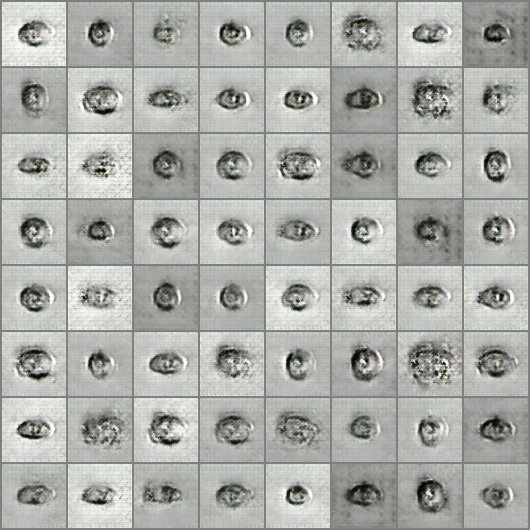

In [50]:
convert_img(generated_data.data, 8)

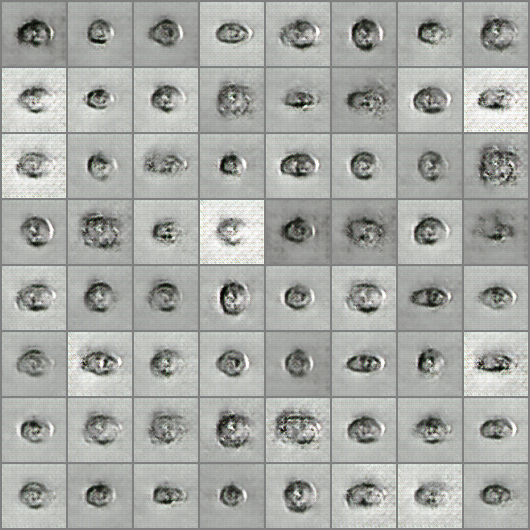

In [75]:
random_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
random_noise = Variable(random_noise.cuda())
generated_data = netG(random_noise)
convert_img(generated_data.data, 8)

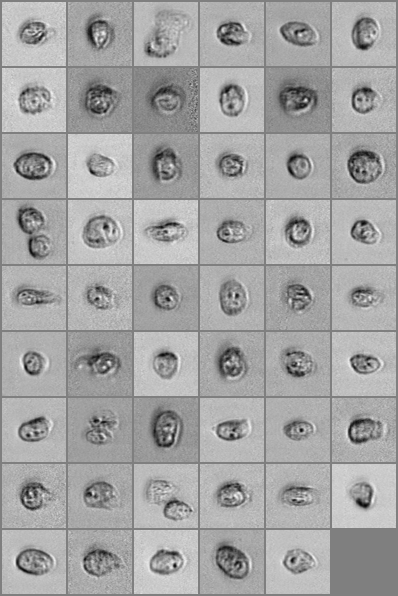

In [85]:
convert_img(real_cpu, 6)